![](img/urban.jpg)

# Image Classification: Urban Sound Classification

This is a very interesting topic to me, cause I never thought of a sound classification task can be analyzed as image classification task through spectrogram.

## [Urban Sounds Dataset](https://urbansounddataset.weebly.com/urbansound8k.html)
This dataset contains 8732 labeled sound exerpts (<=4s) of urban sounds from 10 classes: `air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music`. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excertps are taken from field recordings uploaded to www.freesound.org. The fles are pre-sorted into 10 folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classificaton results reported in the paper.

## Download and unzip

In [1]:
#!wget https://goo.gl/8hY5ER
#!tar xf 8hY5ER

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [3]:
from fastai_dev import *
from fastai_dev.vision import *

plt.style.use(['dark_background'])

## Paths

In [4]:
DATA_PATH = Path('data/urban_sound8k')
AUDIO_PATH = DATA_PATH/'audio'
SPEC_PATH = PATH = DATA_PATH/'spectro'
DATA_PATH.ls()

[PosixPath('data/urban_sound8k/metadata.csv'),
 PosixPath('data/urban_sound8k/spectro'),
 PosixPath('data/urban_sound8k/.DS_Store'),
 PosixPath('data/urban_sound8k/audio')]

Let's listen to a sound

## Data preview

All audio samples are 4 seconds long which fits well with our spectrogram method.

In [5]:
from IPython.display import Audio
Audio(str(AUDIO_PATH/'fold1/26270-9-0-35.wav'))

In [6]:
df = pd.read_csv(DATA_PATH/'metadata.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Generate spectrograms from audio

As mentioned, the folder structure contains 10 predefined validation folds. According to the creators, you should evaluate with this directory structure without any further pre-processing.

> Don't evaluate just on one split. Use 10-fold (not 5-fold) cross validation and average the scores. We strongly advise against this. Instead, perform 10-fold cross validation using the provided folds and report the average score.

By creator's comment and from scoring high perspective, cross validation is highly recommended. However we all know in real producton, cross validataion is rarely be used due to,
1. time consuming
2. you don't want to split the dependent variables if they are time dependent

In [7]:
SPEC_PATH.mkdir(exist_ok=True)

In [8]:
from matplotlib.pyplot import specgram
import librosa
import librosa.display

In [ ]:
def wav2spectrogram(fold):
  
    print(f'++ wav2spectrogram: {fold}')
    
    (SPEC_PATH/f'{fold}').mkdir(exist_ok=True)
    for f in (AUDIO_PATH/f'fold{fold}').glob('*.wav'):
        samples, sr = librosa.load(f)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)       
        fname = SPEC_PATH/f"{fold}/{f.stem}.png"
        S = librosa.feature.melspectrogram(y=samples, sr=sr)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(fname, dpi=400, bbox_inches='tight', pad_inches=0)
        plt.close('all')

In [ ]:
#for i in range(1, 11): wav2spectrogram(i)

## Data preparation and sanity check

The new `data_block` API is definitely the most flexible method to prepare data for training, especially cross-validaton scenario.

In [9]:
folds = range(1, 11)
valid_fos = [1]
train_fos = list(set(folds) - set(valid_fos))
valid_fns = [fn for fo in valid_fos for fn in (PATH/f'{fo}').iterdir()]
train_fns = [fn for fo in train_fos for fn in (PATH/f'{fo}').iterdir()]

tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

pat = r"(\d*)-\d*-\d*.png$"
data = (ImageFileList.from_folder(PATH)
        .label_from_re(pat=pat)
        .split_by_files(valid_fns)
        .datasets(ImageClassificationDataset)
        .transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [10]:
len(data.train_ds), len(data.valid_ds)

(7859, 873)

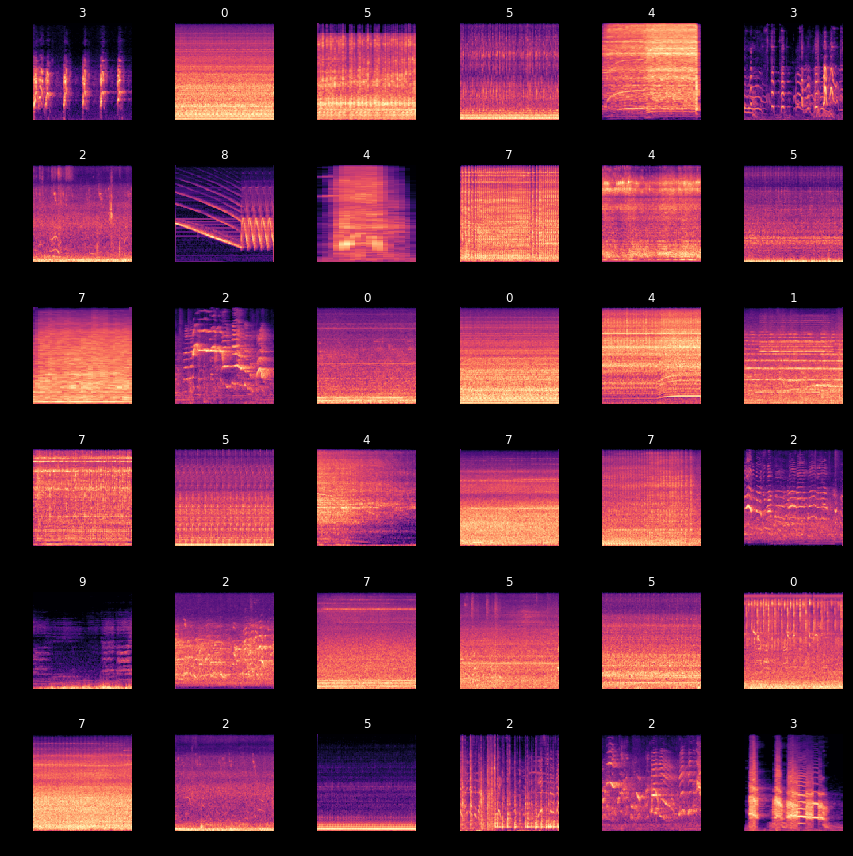

In [11]:
data.show_batch(rows=6, figsize=(12,12))

## Train

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


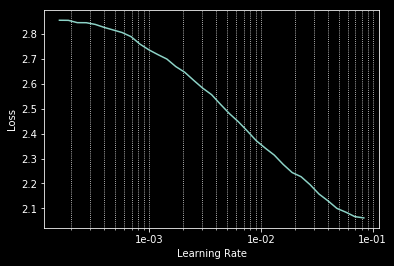

In [26]:
learn.recorder.plot(40,14)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [27]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,2e-2))

Total time: 01:16
epoch  train_loss  valid_loss  error_rate
1      0.817593    1.298306    0.383734    (00:20)
2      0.565342    0.832032    0.273769    (00:18)
3      0.336274    0.695300    0.207331    (00:18)
4      0.167712    0.792577    0.222222    (00:18)



In [28]:
learn.save('cv-1-stage-1')

In [29]:
learn.load('cv-1-stage-1')

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


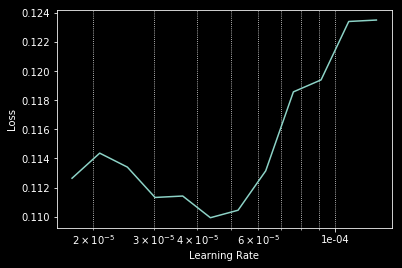

In [38]:
learn.recorder.plot(28, 15)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [39]:
learn.fit_one_cycle(10, max_lr=slice(2e-5,4e-5))

Total time: 04:09
epoch  train_loss  valid_loss  error_rate
1      0.119469    0.790668    0.218786    (00:24)
2      0.097898    0.886607    0.229095    (00:24)
3      0.072541    0.872636    0.234822    (00:24)
4      0.059307    0.997680    0.223368    (00:24)
5      0.040572    1.098987    0.218786    (00:25)
6      0.027713    0.837274    0.191294    (00:24)
7      0.014754    0.853224    0.207331    (00:24)
8      0.010323    0.895046    0.208477    (00:24)
9      0.008371    0.876932    0.209622    (00:25)
10     0.007405    0.901352    0.215349    (00:25)



In [40]:
folds = range(1, 11)
valid_fos = [5]
train_fos = list(set(folds) - set(valid_fos))
valid_fns = [fn for fo in valid_fos for fn in (PATH/f'{fo}').iterdir()]
train_fns = [fn for fo in train_fos for fn in (PATH/f'{fo}').iterdir()]

tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

pat = r"(\d*)-\d*-\d*.png$"
data = (ImageFileList.from_folder(PATH)
        .label_from_re(pat=pat)
        .split_by_files(valid_fns)
        .datasets(ImageClassificationDataset)
        .transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [49]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [42]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


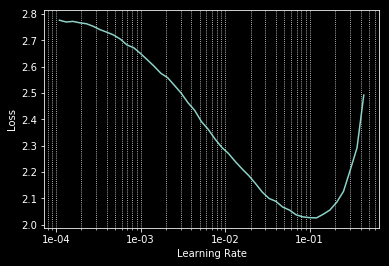

In [45]:
learn.recorder.plot(38)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [50]:
learn.fit_one_cycle(4, max_lr=slice(5e-4,2e-2))

Total time: 01:16
epoch  train_loss  valid_loss  error_rate
1      0.849773    0.860545    0.255342    (00:19)
2      0.596798    0.643536    0.202991    (00:19)
3      0.340511    0.460527    0.146368    (00:19)
4      0.179997    0.474826    0.147436    (00:19)



In [51]:
learn.unfreeze()

In [52]:
learn.unfreeze

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


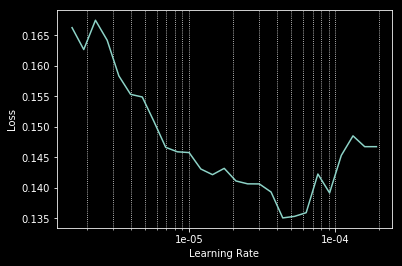

In [56]:
learn.recorder.plot(15, 15)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [57]:
learn.fit_one_cycle(10, max_lr=slice(3e-4,4e-5))

Total time: 04:10
epoch  train_loss  valid_loss  error_rate
1      0.198725    0.486042    0.146368    (00:25)
2      0.196745    0.753046    0.186966    (00:24)
3      0.174240    0.674620    0.155983    (00:24)
4      0.160747    0.749937    0.193376    (00:25)
5      0.105407    0.708772    0.182692    (00:25)
6      0.065782    0.430141    0.134615    (00:25)
7      0.031035    0.419608    0.119658    (00:24)
8      0.016291    0.428926    0.110043    (00:24)
9      0.007772    0.379700    0.103632    (00:25)
10     0.005146    0.387813    0.099359    (00:25)



## Train over 10 folds

In [ ]:
folds = range(1, 11)
for fo in folds:
    
    print(f'++ training: {fo}')
    
    valid_fos = [fo]
    train_fos = list(set(folds) - set(valid_fos)) 
    valid_fns = [fn for fo in valid_fos for fn in (PATH/f'{fo}').iterdir()]
    train_fns = [fn for fo in train_fos for fn in (PATH/f'{fo}').iterdir()]
    
    pat = r"(\d*)-\d*-\d*.png$"
    data = (ImageFileList.from_folder(PATH)
            .label_from_re(pat=pat)
            .split_by_files(valid_fns)
            .datasets(ImageClassificationDataset)
            .transform(tfms=tfms, size=224)
            .databunch(bs=64)
            .normalize(imagenet_stats))
    
    learn = create_cnn(data, models.resnet34, metrics=error_rate)
    
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(9e-4,2e-2))

> 1-0.1*(0.231+0.217+0.258+0.168+0.111+0.191+0.232+0.255+0.134+0.150)

## Further

There are two benchmark in my knowledge,
1. According to the latest [publication](https://arxiv.org/abs/1608.04363) on the [dataset's](https://urbansounddataset.weebly.com/publications.html) website, the state-of-the-art mean accuracy  achieved was 79%. It should be noted that is with extensive audio specific augmentation, and without augmentation their top accuracy was ***74%***.
2. One of member @fastai forum: mean accuracy across the 10 folds of ***80.5%***
> 1-0.1*(0.231+0.217+0.258+0.168+0.111+0.191+0.232+0.255+0.134+0.150)

### TODOs
1. Implement augmentations